# Tesing the Calculation of Convective Organization Potential and Speed it up

In [1]:
%matplotlib inline

import os, sys, glob, copy
import pylab as pl
pl.rcParams['font.size'] = 16.0


#pl.matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import numpy as np
import datetime
import io_tools.netcdf as ncio

from plotting_tools.bmaps import make_map, Basemap
from plotting_tools.colormaps import nice_cmaps, enhanced_colormap
from standard_config import *

## Basic Program from Matthias

In [2]:
# %load ../../tools/fabian_caipy_devel/calculate_COP.py
#####################################################################
#####################################################################
import scipy.spatial

def calculate_COP(ObjCX , ObjCY , ObjArea):
    
    '''
    COP = Convective organization potential according to White et al., 2018, JAS
    Based on the all nearest-neighbour (NN) distances between the centers of mass for each pair of objects
    Impromvment of SCAI because the area of each object in taken into account to address the "interaction potenial"

    INPUT
    =====
    INPUT
    ObjCX:   x-positions of the objects [km]
    ObjCY:   y-positions of the objects [km]
    ObjArea: Object area [km]

    OUTPUT
    ======
    COP: COP index  []
    '''

    # Number of clusters
    N_c = len( ObjCX )

    # Array of shape (N_c,2), containing the coordinates in 
    coords_clm = np.transpose(np.vstack((ObjCX, ObjCY))) # [km]

    # Euclidean Distance between each pair of the two input arrays
    # Output: distance of pairs in a symmetric and trace-less matrix as 
    # two input arrays are identical
    dist_clm = scipy.spatial.distance.cdist(coords_clm,coords_clm, 'euclidean') # [km]
    NumPermu = N_c * (N_c-1) / 2

    V=np.zeros(NumPermu)
    V[:]=np.nan
    Ind=0

    for i in range(0, N_c):
        for j in range(i+1, N_c):
            k      = (N_c*(N_c-1)/2) - (N_c-i)*((N_c-i)-1)/2 + j - i - 1 # index of upper diagonal elements https://stackoverflow.com/questions/27086195/linear-index-upper-triangular-matrix
            Vij    = (np.sqrt(ObjArea[i])+np.sqrt(ObjArea[j])) / ( dist_clm[i,j] * np.sqrt(np.pi) )
            V[Ind] = Vij
            Ind    =Ind+1

    COP=np.sum(V)/NumPermu
    return COP


## Test with random numbers

In [3]:
N = 1000
x = np.random.uniform(0,5, size = N)
y = np.random.uniform(0,5, size = N)
a = np.random.uniform(0.1, 0.2, size = N)

## plotting

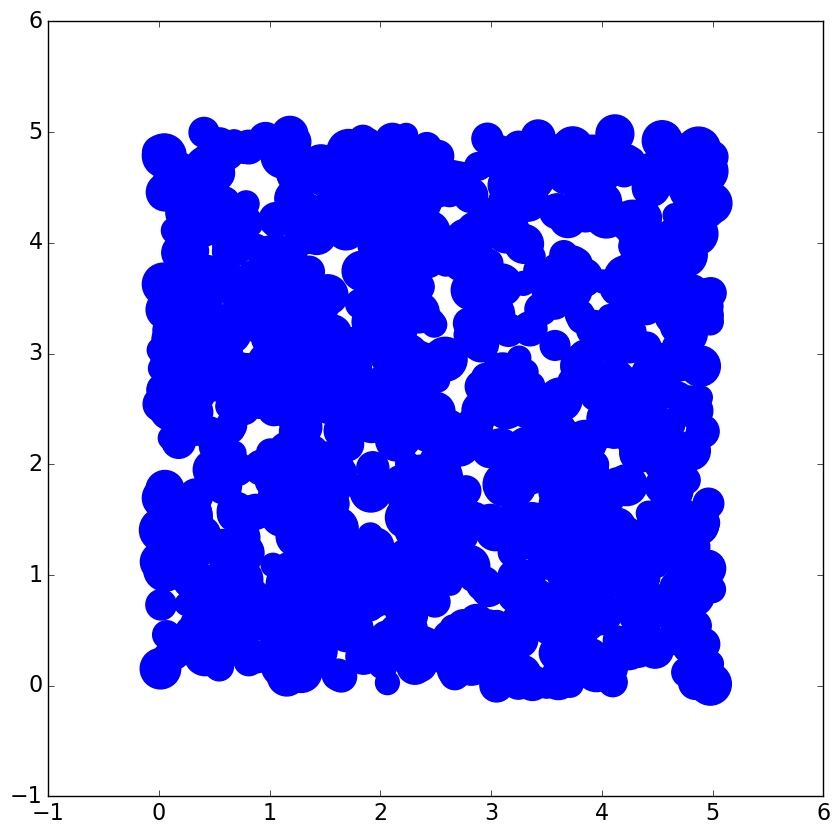

In [4]:
fig, ax = pl.subplots(figsize=(10,10)) 
for i in range(N):
    circ = pl.Circle((x[i], y[i]), a[i], color='b')
    ax.add_artist(circ)
pl.scatter(x,y,s = a)

(array([  93.,  103.,   99.,   93.,  101.,  103.,   91.,  104.,  106.,  107.]),
 array([ 0.10003136,  0.11001402,  0.11999667,  0.12997933,  0.13996199,
         0.14994465,  0.15992731,  0.16990997,  0.17989263,  0.18987529,
         0.19985795]),
 <a list of 10 Patch objects>)

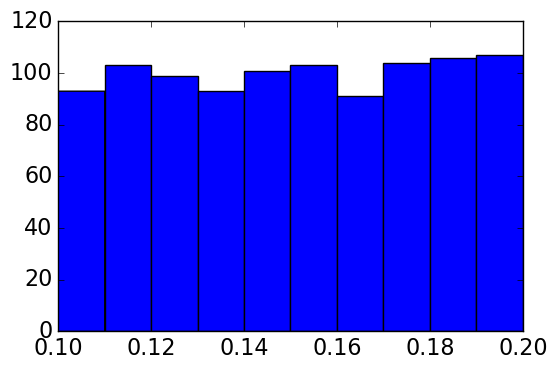

In [5]:
pl.hist(a)

## Try to speed up code using Matrix operaions

In [13]:
%%writefile ../../tools/fabian_caipy_devel/calculate_COP_fast.py

#####################################################################
#####################################################################

import numpy as np
import scipy.spatial

#####################################################################
#####################################################################


def calculate_COP_fast(ObjCX , ObjCY , ObjArea):
    
    '''
    COP = Convective organization potential according to White et al., 2018, JAS
    Based on the all nearest-neighbour (NN) distances between the centers of mass for each pair of objects
    Impromvment of SCAI because the area of each object in taken into account to address the "interaction potenial"

    
    INPUT
    =====
    INPUT
    ObjCX:   x-positions of the objects [km]
    ObjCY:   y-positions of the objects [km]
    ObjArea: Object area [km]

    
    OUTPUT
    ======
    COP: COP index  []
    
    
    HISTORY
    =======
    2018-03-08: first version by Matthias Brueck
    2018-03-09: modifications (vectorization) by Fabian Senf
    '''

    # Number of clusters
    N_c = len( ObjCX )

    # Array of shape (N_c,2), containing the coordinates in 
    coords_clm = np.transpose(np.vstack((ObjCX, ObjCY))) # [km]

    # Euclidean Distance between each pair of the two input arrays
    # Output: distance of pairs in a symmetric and trace-less matrix as 
    # two input arrays are identical
    distance = scipy.spatial.distance.cdist(coords_clm, coords_clm, 'euclidean') # [km]
    
    
    # define the Radius of Objects
    radius = np.sqrt( ObjArea  / np.pi )
    
    
    # the White et al. (2018) COP Defintion has a summed adius matrix in the nominator
    radius_matrix, radius_matrix_T = np.meshgrid( radius, radius)
    
    # per-pair potential
    per_pair_potential = np.ma.divide( radius_matrix + radius_matrix_T, distance ) # masked out distance zero
    
    
    # define the upper triangle 
    #  - the diagonal includes invalid "self" pairing
    #  - the lower triangle has pairs already counted in the upper triangle 
    m = np.triu_indices(N_c, k = 0)

    
    # now we just take the average
    COP = np.ma.mean( per_pair_potential[m] )
    
    return COP


Overwriting ../../tools/fabian_caipy_devel/calculate_COP_fast.py


### Numerical Tests

In [7]:
print calculate_COP(x,y,a)
print calculate_COP_fast(x,y,a)


0.259926343947
0.259926343947


### Run Time Tests

In [8]:
%timeit calculate_COP(x,y,a)

1 loop, best of 3: 1.51 s per loop


In [9]:
%timeit calculate_COP_fast(x,y,a)

10 loops, best of 3: 86.2 ms per loop


In [11]:
speed_up = 1500. / 86.
print speed_up

17.4418604651
